In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
m = ['mf','mb','habit','wsls']

dfp = []
for model in m:
    df = pd.read_csv(f'../../results/{model}/{model}_parameters.csv')
    df.drop(columns=['Unnamed: 0'],inplace=True)
    dfp.append(df)

df_true_param = pd.read_csv('../../results/kdh/kdh_parameters.csv')

param = {'p_0':[],
        'p_1':[]
        }

for i,p in enumerate (df_true_param['p_dh']):
    p = p.replace('[','')
    p = p.replace(']','')
    p = p.replace('  ',' ')
    indices = [z for z, w in enumerate(p) if w == '.']
    x_0 = p[(indices[0]-1):(indices[1]-2)]
    x_1 = p[(indices[1]-1):]
    x_0=float(x_0[:-1])
    x_1=float(x_1[:-1])
        
    param['p_0'].append(x_0)
    param['p_1'].append(x_1)
    
dfp.append(pd.DataFrame(param))

noise_mf=1-(dfp[0]['beta']-dfp[0]['beta'].min())/(dfp[0]['beta'].max()-dfp[0]['beta'].min())
noise_mb=1-(dfp[1]['beta']-dfp[1]['beta'].min())/(dfp[1]['beta'].max()-dfp[1]['beta'].min())
noise_h=1-(dfp[2]['beta']-dfp[2]['beta'].min())/(dfp[2]['beta'].max()-dfp[2]['beta'].min())

a = np.absolute(dfp[3]['p_stay_win'] -.5)
b = np.absolute(dfp[3]['p_shift_lose'] -.5)
ab = a+b 
noise_wsls = 1-(ab-ab.min())/(ab.max()-ab.min())

a = np.absolute(dfp[4]['p_0'] -.5)
b = np.absolute(dfp[4]['p_1'] -.5)
ab = a+b 
noise_kdh = 1-(ab-ab.min())/(ab.max()-ab.min())

df_noise = pd.DataFrame({
                        'noise_mf':noise_mf,
                        'noise_mb':noise_mb,
                        'noise_habit':noise_h,
                        'noise_wsls':noise_wsls,
                        'noise_kdh':noise_kdh}
                        )
df_nlp = pd.read_csv('all_model_nlp.csv')
df_nlp['noise'] = ((df_noise.values).T).flatten()
df_nlp['noise_bins'] = pd.cut(df_nlp['noise'], bins=4,labels=['0','1','2','3'])

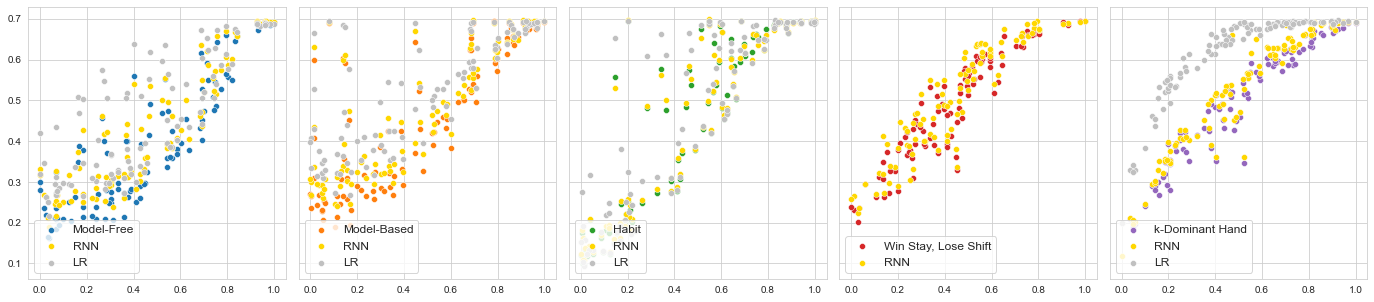

In [3]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(24, 5))
gs = fig.add_gridspec(1,5, hspace=0, wspace=0.05 )
axes = gs.subplots(sharey=True)
models = {
        'mf':[sns.color_palette("tab10")[0],'Model-Free'],
        'mb':[sns.color_palette("tab10")[1],'Model-Based'],
        'habit':[sns.color_palette("tab10")[2],'Habit'],
        'wsls':[sns.color_palette("tab10")[3],'Win Stay, Lose Shift'],
        'kdh':[sns.color_palette("tab10" )[4],'k-Dominant Hand'],
}
for i,m in enumerate(models):
    data = (df_nlp.iloc[i*100:i*100+100]).reset_index()
    y_0 = data[f'test_nlp_{m}'] - data['best_test_nlp_rnn']
    y_1 = data[f'test_nlp_{m}'] - data['test_nlp_logistic_regression']
    sns.scatterplot(ax=axes[i],x=df_noise[f'noise_{m}'],y=data[f'test_nlp_{m}'],color=models[m][0],label=models[m][1])
    sns.scatterplot(ax=axes[i],x=df_noise[f'noise_{m}'],y=data['best_test_nlp_rnn'],label='RNN',color='gold')
    if i !=3:
        sns.scatterplot(ax=axes[i],x=df_noise[f'noise_{m}'],y=data['test_nlp_logistic_regression'],label='LR',color='silver')
    
    axes[i].set_xlabel('',size=12)
    axes[i].set_ylabel('')
    axes[i].legend(loc='lower left',fontsize=12)

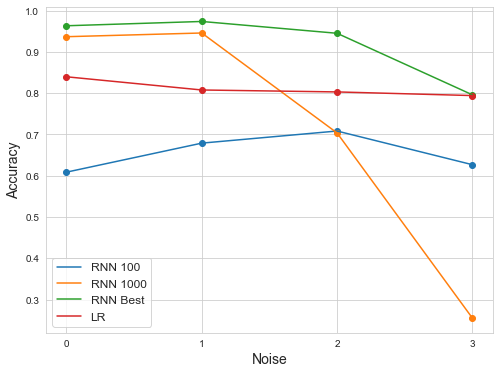

In [4]:
from sklearn.metrics import accuracy_score

models = ['mf','mb','habit','wsls','kdh']
class_by = ['test_nlp_rnn_100','test_nlp_rnn_1000','best_test_nlp_rnn','test_nlp_logistic_regression']

all_acc = np.zeros(shape=(len(models),len(class_by),4))

bin_0 = df_nlp[(df_nlp['noise_bins'] == '0') ]
bin_1 = df_nlp[(df_nlp['noise_bins'] == '1') ]
bin_2 = df_nlp[(df_nlp['noise_bins'] == '2') ]
bin_3 = df_nlp[(df_nlp['noise_bins'] == '3') ]

noise_level = [bin_0,bin_1,bin_2,bin_3]

for i,m in enumerate(models):
    for j, cla in enumerate(class_by):
        for k, bins in enumerate(noise_level):
            bins.loc[ (bins['model'] == f'{m}') ,'label'] = 0
            bins.loc[ (bins['model'] != f'{m}') ,'label'] = 1
            y_pred = (np.array(bins[f'test_nlp_{m}'] - bins[cla]) > 0).astype(int)
            y_true = np.array(bins['label'])
            all_acc[i,j,k] = accuracy_score(y_true=y_true,y_pred=y_pred)
            
a = all_acc[:,0,:].mean(axis=0)
b = all_acc[:,1,:].mean(axis=0)
c = all_acc[:,2,:].mean(axis=0)
d = all_acc[:,3,:].mean(axis=0)

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
plt.plot(a)
plt.scatter([0,1,2,3],a)
plt.plot(b)
plt.scatter([0,1,2,3],b)
plt.plot(c)
plt.scatter([0,1,2,3],c)
plt.plot(d)
plt.scatter([0,1,2,3],d)
plt.ylabel('Accuracy',size=14)
plt.xticks([0,1,2,3])
plt.xlabel('Noise',size=14)
plt.legend(['RNN 100','RNN 1000','RNN Best','LR'],fontsize=12,loc='lower left')